In [481]:
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeClassifier
from sklearn import datasets
from sklearn.preprocessing import LabelBinarizer

from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt


def calculate_ridge(X_param, y_param, k):
    return np.linalg.pinv((X_param.T @ X_param) + (k * np.identity(len(X_param.T)))) @ (X_param.T @ y_param)


def calculate_ridge2(mX, my, k):
    mXt = mX.transpose()
    mXt_times_mX = np.matmul(mXt, mX)
    ide = np.identity(len(mXt_times_mX))
    identity = np.dot(k, ide)
    mXt_mX_plus_identity = np.add(mXt_times_mX, identity)
    inverse_mXt_mX_plus_identity = np.linalg.pinv(mXt_mX_plus_identity)
    mXt_times_my = np.matmul(mXt, my)
    final = np.matmul(inverse_mXt_mX_plus_identity, mXt_times_my)

    return final


def my_normalize(matrix):
    return (matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))


noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

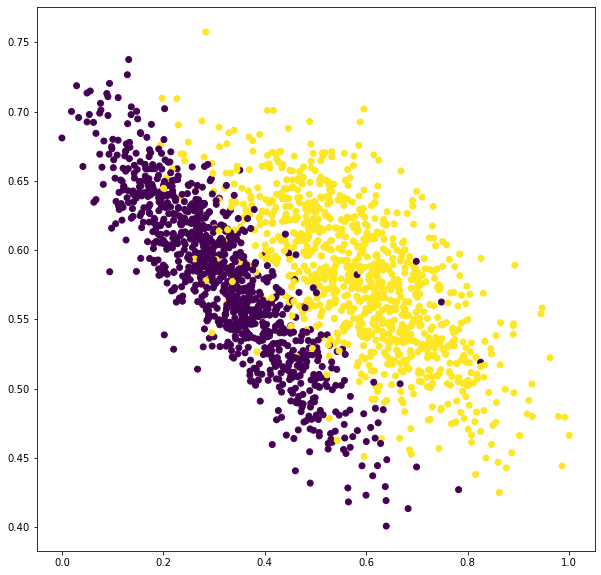

In [482]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

mesh = np.meshgrid(arange(0, 1.1, 0.01), arange(0, 1.1, 0.01))[0]


X_train = my_normalize(X_train)
y_train = my_normalize(y_train)
X_test = my_normalize(X_test)
y_test = my_normalize(y_test)


plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

[[4.93668022 7.90817282]]
[ 1.58257201 -0.35494987]
KOX 
 [[200  35]
 [ 51 199]] 0.822680412371134


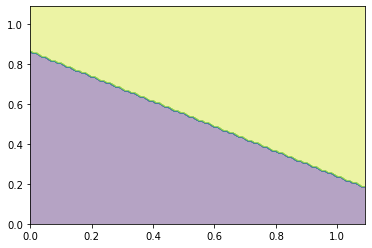

In [483]:
def calculate_value(theta, pX):
    return pX @ theta


def label_data(data, mean):
    ans = list()
    for x in data:
        if x >= mean:
            ans.append(1.0)
        else:
            ans.append(0.0)
    return np.asarray(ans)

model_ridge = RidgeClassifier(copy_X=True)
model_ridge.fit(X_train, y_train)

print(model_ridge.coef_)
my_ridge = calculate_ridge(X_train, y_train, 0.1)
print(my_ridge)

predict = model_ridge.predict(c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
y_predicted = calculate_value(my_ridge, X_test)

mean = np.mean(y_predicted)

# conf = confusion_matrix(y_test, predict)
# print("NIEKOX\n", conf, accuracy_score(y_test, predict))

huj = label_data(y_predicted, mean)
conf = confusion_matrix(y_test, huj)
print("KOX \n",conf, accuracy_score(y_test, huj))
conf

plt.contourf(mesh, mesh.T, predict, alpha=0.4)